In [1]:
# Importing requird python packages
# Path to hsmpy package
HSMPY_PATH = r'\\CHCFPP01\Guest\MRajabi\Python Scripts'
import sys, os, arcpy, csv, json, math
sys.path.append(HSMPY_PATH)
import hsmpy3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.core.display import HTML 
import subprocess 
import webbrowser
import time
import copy
import shutil
from time import gmtime, strftime
from ipywidgets import FloatProgress
print(strftime("%Y-%m-%d %H:%M:%S"))

2019-01-09 10:31:34


In [2]:
# Defining Parameteres
print(strftime("%Y-%m-%d %H:%M:%S"))
Years = range(2012,2017)
MaxOpenProcesses = 15
Project_DIR  = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO00_OtherStates\NewMexico\3_WorkData\7_NetworkScreening'
ReceivedDir  = Project_DIR + '\\2.Received_Data'
Project_GDB  = Project_DIR + '\\5.NM_NS_GDB.gdb'
PythonDir   = Project_DIR + '\\6.Python_Notebook'

Src_Loc  = ReceivedDir + '\\crash_asof_11jun2018.csv'
Src_Unit = ReceivedDir + '\\vehicle_asof_11jun2018.csv'
Src_Occ  = ReceivedDir + '\\occupant_asof_11jun2018.csv'

Src_Ped_Loc  = ReceivedDir + '\\Ped_2017_KAB\\crashkabped.csv'
Src_Ped_Unit = ReceivedDir + '\\Ped_2017_KAB\\vehiclekabped.csv'
Src_Ped_Occ  = ReceivedDir + '\\Ped_2017_KAB\\occkabped.csv'

HPMS105 = {year:ReceivedDir + '\\v105\\jg_request.gdb\\HPMS{}Data'.format(year) for year in Years}
HPMS10  = {year:ReceivedDir + '\\v10\\jg_request.gdb\\HPMS{}Data'.format(year) for year in Years}

FOU_2017_105 = ReceivedDir + '\\v105\\jg_request.gdb\\HPMS2017Ownership_Urban_FuncSys'
FOU_2017_10  = ReceivedDir + '\\v10\\jg_request.gdb\\HPMS2017Ownership_Urban_FuncSys'

FHWA_HPMS     = {year:ReceivedDir + '\\FHWA_HPMS\\newmexico{}\\NewMexico{}.shp'.format(year,year) for year in Years}
MS2_HPMS_2017 = {year:ReceivedDir + '\\NM_HPMS_N2017_A{}.csv'.format(year) for year in Years}

Routes  = {year:Project_GDB + '\\Routes_{}'.format(year) for year in Years}
AttTabs = {year:Project_GDB + '\\SegAtt_{}'.format(year) for year in Years}
Segs    = {year:Project_GDB + '\\Seg_{}'.format(year) for year in Years}
CrashData = {year:Project_GDB + '\\Crash_{}'.format(year) for year in range(2012,2018)}

UTM13N   = arcpy.SpatialReference(26913)
NAD83_NM = arcpy.SpatialReference(6529)

RouteID = "ROUTE_ID"
BEG_STA = 'BEG_POINT'
END_STA = 'END_POINT'
Fields = ['F_SYSTEM','THROUGH_LANES','FACILITY_TYPE','AADT','MEDIAN_TYPE','SPEED_LIMIT','LANE_WIDTH']

2019-01-09 10:31:34


In [9]:
df = hsmpy3.common.FCtoDF(FOU_2017_105,False,['DATA_ITEM',END_STA,BEG_STA])
for f in ["F_SYSTEM","URBAN_CODE","OWNERSHIP"]:
    df1 = df[df.DATA_ITEM==f]
    leng = [r[END_STA]-r[BEG_STA] for i,r in df1.iterrows()]
    print(f,sum(leng))

F_SYSTEM 80253.21805570368
URBAN_CODE 80282.16005506553
OWNERSHIP 80286.56305479445


In [35]:
for year in range(2012,2017):
    fc = Project_GDB + '\\Crash_{}'.format(year)
    arcpy.management.AddField(fc,'CID','Text',50)
    uc = arcpy.UpdateCursor(fc)
    for row in uc:
        ucr = row.getValue('UCRnum')
        row.setValue('CID','{}_{}'.format(year,ucr))
        uc.updateRow(row)
    del uc
    del row
    print(year)

2012
2013
2014
2015
2016


In [3]:
Loc_DF = pd.read_csv(Src_Loc,low_memory=False)
Loc_DF['CID'] = ['{}_{}'.format(y,u) for y,u in zip(Loc_DF.year,Loc_DF.UCRnumber)]
#Loc_DF.to_excel(ReceivedDir + '\\Loc_Input.xlsx',index = False)
#arcpy.Delete_management(Project_GDB + '\\Loc_Input')
#arcpy.TableToTable_conversion(in_rows=ReceivedDir + '\\Loc_Input.xlsx',out_path=Project_GDB,out_name='Loc_Input')
Loc_DF.index = ['{}_{}'.format(y,u) for y,u in zip(Loc_DF.year,Loc_DF.UCRnumber)]
Loc_DF = Loc_DF.sort_index()

In [4]:
Unit_DF = pd.read_csv(Src_Unit,low_memory=False)
Unit_DF['CUID'] = ['{}_{}_{}'.format(y,u,v) for y,u,v in zip(Unit_DF.year, Unit_DF.UCRnumber,Unit_DF.VehNo)]
Unit_DF['CID'] = ['{}_{}'.format(y,u) for y,u in zip(Unit_DF.year, Unit_DF.UCRnumber)]
#Unit_DF.to_excel(ReceivedDir + '\\Unit_Input.xlsx',index = False)
#arcpy.Delete_management(Project_GDB + '\\Unit_Input')
#arcpy.TableToTable_conversion(in_rows=ReceivedDir + '\\Unit_Input.xlsx',out_path=Project_GDB,out_name='Unit_Input')
Unit_DF.index = pd.MultiIndex.from_tuples([('{}_{}'.format(y,u),v) for y,u,v in zip(Unit_DF.year, Unit_DF.UCRnumber,Unit_DF.VehNo)],names=['CID','Unit'])
Unit_DF = Unit_DF.sort_index()

In [5]:
OL = ['CUID','PPLNo', 'OccNo', 'SeatPos', 'Age', 'Sex', 'Injury', 'OPCode', 'OPProperlyUsed', 'AirbagDeployed', 'Ejected', 'MedTrans', 'DAparked', 'Belt', 'Helmet']
Occ_DF = pd.read_csv(Src_Occ,low_memory=False)
Occ_DF['CUID'] = ['{}_{}_{}'.format(y,u,v) for y,u,v,p in zip(Occ_DF.year, Occ_DF.UCRnumber,Occ_DF.VehNo,Occ_DF.PPLNo)]
#Occ_DF[OL].to_csv(ReceivedDir + '\\Occ_Input.csv',index = False)
#arcpy.Delete_management(Project_GDB + '\\Occ_Input')
#arcpy.TableToTable_conversion(in_rows=ReceivedDir + '\\Occ_Input.csv',out_path=Project_GDB,out_name='Occ_Input')
Occ_DF.index = pd.MultiIndex.from_tuples([('{}_{}'.format(y,u),v,p) for y,u,v,p in zip(Occ_DF.year, Occ_DF.UCRnumber,Occ_DF.VehNo,Occ_DF.PPLNo)],names=['CID','Unit','Person'])
Occ_DF = Occ_DF.sort_index()

In [93]:
def LR_Overlay(Tab1,Tab2,Output):
    arcpy.lr.OverlayRouteEvents(
        in_table                 = Tab1,
        in_event_properties      = ' '.join([RouteID,'LINE',BEG_STA,END_STA]), 
        overlay_table            = Tab2, 
        overlay_event_properties = ' '.join([RouteID,'LINE',BEG_STA,END_STA]),
        overlay_type             = "UNION", 
        out_table                = Output, 
        out_event_properties     = ' '.join([RouteID,'LINE',BEG_STA,END_STA]),
        zero_length_events       = "ZERO", 
        in_fields                = "FIELDS", 
        build_index              = "INDEX"
    )
def FindFType(RID,F_SYSTEM,FACILITY_TYPE,THROUGH_LANES,URBAN_CODE,MEDIAN_TYPE):
    if FACILITY_TYPE==2 and THROUGH_LANES>0:
        S1 = 'U'
        if URBAN_CODE in [99999,0]:
            S1 = 'R'

        S2 = str(int(THROUGH_LANES))
        if THROUGH_LANES in [3,5,7,9] and F_SYSTEM == 1:
            S2 = str(int(THROUGH_LANES-1))

        S3 = 'U'
        if MEDIAN_TYPE in [2,3,4,5,6,7]:
            S3 = 'D'
        if F_SYSTEM in [1,2]:
            S3 = 'F'
        if F_SYSTEM == 7:
            S3 = 'L'
        return (S1+S2+S3)
    else:
        if 'X' in RID:
            return('Ramp')
        return('')

In [4]:
# Read Data
print(strftime("%Y-%m-%d %H:%M:%S"))

#Att_Dict = {year:hsmpy3.common.AttributeTabletoDF(HPMS105[year]) for year in Years}

#AttTab_Dict = {year:hsmpy3.common.AttributeTabletoDF(AttTabs[year]) for year in Years}

#Segs_Dict = {year:hsmpy3.common.AttributeTabletoDF(Segs[year]) for year in Years}

#FHWA_HPMS_Dict = {year:hsmpy3.common.AttributeTabletoDF(FHWA_HPMS[year]) for year in Years}

#MS2_HMPS_Dict = {year:pd.read_csv(MS2_HPMS_2017[year]) for year in Years}

2018-07-23 09:02:40


In [6]:
# Geocode Crash Data
print(strftime("%Y-%m-%d %H:%M:%S"))
hsmpy3.nm.GeocodeCrashes(Src_Loc,Src_Unit,Src_Occ,CrashData,range(2012,2017))
hsmpy3.nm.GeocodeCrashes(Src_Ped_Loc,Src_Ped_Unit,Src_Ped_Occ,CrashData,[2017])
print(strftime("%Y-%m-%d %H:%M:%S"))

2012 4433 0.9345815474847733
2013 4252 0.956961429915334
2014 4459 0.9863198026463332
2015 4912 0.9981677524429967
2016 5050 0.9996039603960396


In [45]:
# Read Crash Data
print(strftime("%Y-%m-%d %H:%M:%S"))
Crash_DF = pd.concat([hsmpy3.common.FCtoDF(CrashData[year],readGeometry=True) for year in range(2012,2018)])
Crash_DF['Year'] = [d.year for d in Crash_DF.Date]
Crash_DF['PedCrashCount'] = [{True:1,False:0}[sum([k,a,b])>0] for k,a,b in zip(Crash_DF.PedK,Crash_DF.PedA,Crash_DF.PedB)]
Crash_DF['Count'] = 1
Crash_DF.index = ['{}_{}'.format(y,u) for u,y in zip(Crash_DF.UCRnum,Crash_DF.Year)]
Crash_DF.groupby(['Year'])['Count','Killed','ClassA','ClassB','PedCrashCount','PedK','PedA','PedB'].aggregate(np.sum)
print(strftime("%Y-%m-%d %H:%M:%S"))

2019-01-09 11:45:26


C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


2019-01-09 11:47:11


In [46]:
Crash_DF

,CID,ClassA,ClassB,Date,FType,F_SYSTEM,GIS_Route,IFType,Int_ID,Int_Related,...,RID,RID_P,SegID,SegID_P,Shape,UCRnum,URBAN_CODE,Year,PedCrashCount,Count
2012_10027290,2012_10027290,0,1,2012-09-11 16:10:00.000000,R2L,7.0,nan,None,42981.0,1.0,...,LOC-148273-P,LOC-148273-P,LOC-148273-P_0.0000_0.1200,NaN,(903173.186297745 1647737.71462674 NaN 0),10027290,99999.0,2012,0,1
2012_10153388,2012_10153388,0,0,2012-02-16 10:26:00.000000,U4U,3.0,nan,U4ST,6038.0,1.0,...,US-64-P,US-64-P,US-64-P_63.8620_64.1770,NaN,(1132764.33899116 2082783.22937649 NaN 0),10153388,99998.0,2012,1,1
2012_10153400,2012_10153400,1,1,2012-03-06 16:35:00.000000,U4U,3.0,nan,U4ST,2566.0,1.0,...,US-64-P,US-64-P,US-64-P_60.2740_63.8620,NaN,(1129656.73464208 2082809.55248657 NaN 0),10153400,99998.0,2012,0,1
2012_10303496,2012_10303496,0,1,2012-05-07 02:40:00.000000,R2L,7.0,nan,None,0.0,0.0,...,LOC-308196-P,LOC-308196-P,LOC-308196-P_0.0000_0.1680,NaN,(1570778.24872275 1525207.1217619 NaN 0),10303496,0.0,2012,0,1
2012_10395450,2012_10395450,1,0,2012-01-02 11:28:00.000000,U2U,6.0,nan,None,0.0,0.0,...,FL-1724-P,FL-1724-P,FL-1724-P_0.0000_2.4200,NaN,(1515310.82160008 1447373.65866274 NaN 0),10395450,1171.0,2012,0,1
2012_10395480,2012_10395480,0,1,2012-01-09 21:00:00.000000,Ramp,1.0,nan,None,0.0,0.0,...,IX-40-P-175.0-V,IX-40-P-175.0-V,IX-40-P-175.0-V_0.0000_0.0400,NaN,(1601267.92133908 1487232.76529607 NaN 0),10395480,1171.0,2012,0,1
2012_10395507,2012_10395507,0,1,2012-01-17 06:32:00.000000,R4F,1.0,I 40W,None,0.0,0.0,...,I-40-M,I-40-P,I-40-P_140.2900_144.5150,NaN,(1440872.36253766 1470141.54127649 NaN 0),10395507,99999.0,2012,0,1
2012_10395508,2012_10395508,0,1,2012-01-17 07:21:00.000000,R4F,1.0,I 40W,None,0.0,0.0,...,I-40-M,I-40-P,I-40-P_140.2900_144.5150,NaN,(1440872.36253766 1470141.54127649 NaN 0),10395508,99999.0,2012,0,1
2012_10395543,2012_10395543,0,1,2012-01-21 12:12:00.000000,U4U,3.0,nan,U3ST,10577.0,1.0,...,FL-4014-P,FL-4014-P,FL-4014-P_2.0940_2.6280,NaN,(1506618.49219999 1480060.18351266 NaN 0),10395543,1171.0,2012,0,1
2012_10395561,2012_10395561,2,0,2012-01-25 07:50:00.000000,U4U,3.0,nan,U3ST,26076.0,1.0,...,NM-45-P,NM-45-P,NM-45-P_3.8800_5.5030,NaN,(1499837.64158849 1444125.11791574 NaN 0),10395561,1171.0,2012,0,1


C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [89]:
# Export Snapped Crashes
print(strftime("%Y-%m-%d %H:%M:%S"))
SnapExport = Crash_DF.copy(True)
SnapExport['XY'] = ['{}_{}'.format(s.firstPoint.X,s.firstPoint.Y) for s in SnapExport.Shape]
df = pd.DataFrame(SnapExport.XY.value_counts())
df.columns = ['CrashesAtThisLoc']
df['XY'] = list(df.index)
df['LocIndex'] = np.arange(1,len(df)+1)

baseurl = 'https://www.google.com/maps/search/?api=1&query={},{}'.format
SnapExport['Longitude'] = [pnt.projectAs(hsmpy3.common.WGS1984)[0].X for pnt in list(Crash_DF.Shape)]
SnapExport['Latitude' ] = [pnt.projectAs(hsmpy3.common.WGS1984)[0].Y for pnt in list(Crash_DF.Shape)]
SnapExport['Link' ] = [baseurl(y,x) for x,y in zip(SnapExport.Longitude,SnapExport.Latitude)]
SnapExport = SnapExport.join(df[['LocIndex','CrashesAtThisLoc']], on='XY',lsuffix='2')
SnapExport.index = pd.MultiIndex.from_tuples(list(zip(*[list(SnapExport.LocIndex),
                                                        list(SnapExport.CrashesAtThisLoc),
                                                        list(SnapExport.Link),
                                                        list(SnapExport.Year),
                                                        [int(i) for i in list(SnapExport.UCRnum)]])), names=['LocIndex','CrashesAtThisLoc','Link','Year','UCRNumber'])
SnapExport.Date = SnapExport.Date.dt.strftime('%Y-%m-%d %H:%M')
SnapExport = SnapExport.sort_values(by=['LocIndex','Date'])
SnapExport = SnapExport[SnapExport.CrashesAtThisLoc>1][['Date']]
SnapExport.columns.name = 'Snapped Crashes'
SnapExport.to_excel('SnappedCrashes.xlsx')
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-08-08 14:30:08
2018-08-08 14:30:17


In [5]:
#Create Routes:
print(strftime("%Y-%m-%d %H:%M:%S"))
p = hsmpy3.network.CON_CreateRoutes(PythonDir,HSMPY_PATH,Input=HPMS105[2016],
                            RID='ROUTE_ID',BMP='BEG_POINT',EMP='END_POINT',
                            Output=Routes[2016],SpatRef=6529,Tolerance=10,Title='2016')
p.wait()
arcpy.edit.ExtendLine(in_features=Routes[2016],length='15 Feet',extend_to='FEATURE')
hsmpy3.nm.CON_AddRouteDirection(HSMPY_PATH,PythonDir,Routes[2016])

In [8]:
#Create Individual Attribute Table
print(strftime("%Y-%m-%d %H:%M:%S"))
#Att_Dict = {year:hsmpy3.common.AttributeTabletoDF(HPMS105[year]) for year in Years}
Fields = []
for year in Att_Dict.keys():
    Fields.extend(list(set(Att_Dict[year]['DATA_ITEM'])))
Fields = list(set(Fields))
LR_Fields = [RouteID,BEG_STA,END_STA]
c = LR_Fields
c.extend(Fields)
for year in Years:
    print(year)
    Data_Items = list(set(Att_Dict[year]['DATA_ITEM']))
    for di in Data_Items:
        print(di)
        df = Att_Dict[year]
        df = df[df.DATA_ITEM==di]
        LR_Fields = [RouteID,BEG_STA,END_STA]
        c = [k for k in LR_Fields]
        c.append('VALUE_NUME')
        df = df[c]
        df.rename(columns={'VALUE_NUME': di}, inplace=True)
        N = hsmpy3.common.CreateOutPath(Project_GDB+'\\' + di,str(year),'')
        arcpy.management.CreateTable(out_name=os.path.basename(N),out_path=Project_GDB)
        arcpy.management.AddField(N,RouteID,'Text')
        arcpy.management.AddField(N,BEG_STA,'Double')
        arcpy.management.AddField(N,END_STA,'Double')
        if di in ['F_SYSTEM','FACILITY_TYPE','THROUGH_LANES','MEDIAN_TYPE','SPEED_LIMIT']:
            f_type = 'Short'
        if di in ['AADT']:
            f_type = 'Long'
        if di in ['LANE_WIDTH']:
            f_type = 'Float'
        arcpy.management.AddField(N,di,f_type)
        ic = arcpy.InsertCursor(N)
        for i,r in df.iterrows():
            row = ic.newRow()
            row.setValue(RouteID,r[RouteID])
            row.setValue(BEG_STA,r[BEG_STA])
            row.setValue(END_STA,r[END_STA])
            if di in ['F_SYSTEM','FACILITY_TYPE','THROUGH_LANES','MEDIAN_TYPE','SPEED_LIMIT','AADT']:
                row.setValue(di,ConvToInt(r[di]))
            if di in ['LANE_WIDTH']:
                row.setValue(di,ConvToFloat(r[di]))
            ic.insertRow(row)
        del ic

2018-07-20 11:56:06
2012
AADT
F_SYSTEM
FACILITY_TYPE
LANE_WIDTH
MEDIAN_TYPE
SPEED_LIMIT
2013
AADT
F_SYSTEM
FACILITY_TYPE
LANE_WIDTH
MEDIAN_TYPE
THROUGH_LANES
SPEED_LIMIT
2014
AADT
F_SYSTEM
FACILITY_TYPE
LANE_WIDTH
MEDIAN_TYPE
THROUGH_LANES
SPEED_LIMIT
2015
AADT
F_SYSTEM
FACILITY_TYPE
LANE_WIDTH
MEDIAN_TYPE
THROUGH_LANES
SPEED_LIMIT
2016
AADT
F_SYSTEM
FACILITY_TYPE
LANE_WIDTH
MEDIAN_TYPE
THROUGH_LANES
SPEED_LIMIT


In [95]:
# Data Elements Mileage
print(strftime("%Y-%m-%d %H:%M:%S"))
#Att_Dict = {year:hsmpy3.common.AttributeTabletoDF(HPMS105[year]) for year in Years}
DataCoverage = pd.DataFrame(columns = Fields)
DataCoverage['Year'] = Years
DataCoverage.index = Years
for year in Years:
    for f in Fields:
        #try:
            #leng = [r.getValue(END_STA)-r.getValue(BEG_STA) for r in arcpy.SearchCursor(Project_GDB + '\\{}_{}'.format(f,year))]
            df = Att_Dict[year][Att_Dict[year].DATA_ITEM==f]
            leng = [r[END_STA]-r[BEG_STA] for i,r in df.iterrows()]
            DataCoverage.set_value(year,f,sum(leng))
        #except:pass
pd.options.display.float_format = '{:,.2f}'.format
display(DataCoverage)

2018-07-20 10:08:41


,F_SYSTEM,URBAN_CODE,OWNERSHIP,FACILITY_TYPE,THROUGH_LANES,MEDIAN_TYPE,LANE_WIDTH,AADT,SPEED_LIMIT,Year
2012,"14,921.21",0,0,"17,803.61",0,"2,511.20","2,511.20","29,383.69","2,511.20",2012
2013,"10,988.14",0,0,"11,069.57","11,077.67","2,424.27","2,425.79","13,786.80","2,425.79",2013
2014,"11,148.60",0,0,"11,148.60","11,713.36","2,270.13","2,270.13","13,491.44","2,270.13",2014
2015,496.69,0,0,"12,651.44","12,774.31","2,069.58","2,069.58","15,363.12","2,069.58",2015
2016,"80,337.04",0,0,"80,337.04","77,493.86","1,651.65","1,651.65","69,797.31","1,651.65",2016


In [38]:
#Create Individual Attribute Table 2017
print(strftime("%Y-%m-%d %H:%M:%S"))
#FOU_DF = hsmpy3.common.AttributeTabletoDF(FOU_2017_105)
Fields = list(set(FOU_DF['DATA_ITEM']))
LR_Fields = [RouteID,BEG_STA,END_STA]
year= 2017
for di in Fields:
        print(di)
        df = FOU_DF[FOU_DF.DATA_ITEM==di]
        c = [k for k in LR_Fields]
        c.append('VALUE_NUME')
        df = df[c]
        df.rename(columns={'VALUE_NUME': di}, inplace=True)
        N = hsmpy3.common.CreateOutPath(Project_GDB+'\\' + di,str(year),'')
        arcpy.management.CreateTable(out_name=os.path.basename(N),out_path=Project_GDB)
        arcpy.management.AddField(N,RouteID,'Text')
        arcpy.management.AddField(N,BEG_STA,'Double')
        arcpy.management.AddField(N,END_STA,'Double')
        arcpy.management.AddField(N,di,'Long')
        ic = arcpy.InsertCursor(N)
        for i,r in df.iterrows():
            row = ic.newRow()
            row.setValue(RouteID,r[RouteID])
            row.setValue(BEG_STA,r[BEG_STA])
            row.setValue(END_STA,r[END_STA])
            row.setValue(di,r[di])
            ic.insertRow(row)
        del ic

2018-07-17 08:44:58
OWNERSHIP
F_SYSTEM
URBAN_CODE


In [98]:
#Overlay Attribute Table and Create Segments using each years routes, Takes 2 hours
print(strftime("%Y-%m-%d %H:%M:%S"))
Routes  = {year:Project_GDB + '\\Routes_' + str(year) for year in Years}
AttTabs = {year:Project_GDB + '\\SegAtt_' + str(year) for year in Years}
Segs    = {year:Project_GDB + '\\Seg_'    + str(year) for year in Years}

#D1_L = ['F_SYSTEM_2016'          ,'SegAtt_temp1'  ,'SegAtt_temp2'   ,'SegAtt_temp1'       ,'SegAtt_temp2'       ,'SegAtt_temp1'      ,'SegAtt_temp2'    ]
#D2_L = ['FACILITY_TYPE_2016'     ,'OWNERSHIP_2017','URBAN_CODE_2017','THROUGH_LANES_2016' ,'MEDIAN_TYPE_2016'   ,'LANE_WIDTH_2016'   ,'SPEED_LIMIT_2016']
#OID_L =['temp1'                  ,'temp2'         ,'temp1'          ,'temp2'              ,'temp1'              ,'temp2'             ,'NoAADT_Table'    ]
#for D1,D2,OutID in zip(D1_L,D2_L,OID_L):
#        Out = hsmpy3.common.CreateOutPath(Project_GDB+'\\SegAtt',OutID,'')
#        LR_Overlay(os.path.join(Project_GDB,D1),os.path.join(Project_GDB,D2),Out)
#        print(D1,D2,os.path.basename(Out),str(arcpy.management.GetCount(Out)))#,str([f.name for f in arcpy.ListFields(Out)]))

Fields = ['F_SYSTEM','URBAN_CODE','OWNERSHIP','FACILITY_TYPE','THROUGH_LANES','MEDIAN_TYPE','LANE_WIDTH','AADT','SPEED_LIMIT']
for year in [2012,2013,2014,2015,2016]:
    year = str(year)
    D1 = 'SegAtt_NoAADT_Table'
    D2 = 'AADT_' + str(year)
    OutID = 'Initial_' + str(year)
    Out = hsmpy3.common.CreateOutPath(Project_GDB+'\\SegAtt',OutID,'')
    LR_Overlay(os.path.join(Project_GDB,D1),os.path.join(Project_GDB,D2),Out)
    print(year,D1,D2,os.path.basename(Out),str(arcpy.management.GetCount(Out)))#,str([f.name for f in arcpy.ListFields(Out)]))
    OutSeg = hsmpy3.common.CreateOutPath(Project_GDB+'\\SegMulti',year,'')
    hsmpy3.network.CreateRouteEventLayer(
        Sites_Routes = Routes[2016],
        AttTable     = Out,
        RouteID      = RouteID,
        BMP          = BEG_STA,
        EMP          = END_STA,
        Fields       = Fields,
        Output       = OutSeg)
    try:
        arcpy.management.Delete(Segs[int(year)])
    except:pass
    arcpy.management.MultipartToSinglepart(in_features=OutSeg,out_feature_class=Segs[int(year)])
    uc = arcpy.UpdateCursor(Segs[int(year)])
    for row in uc:
        s = row.getValue('Shape')
        row.setValue(BEG_STA,s.firstPoint.M)
        row.setValue(END_STA,s.lastPoint.M)
        uc.updateRow(row)
    del uc
    del row
    
    arcpy.management.DeleteIdentical(in_dataset=Segs[int(year)],fields=['ROUTE_ID','BEG_POINT','END_POINT'])

    arcpy.management.AddField(Segs[int(year)],'SegID','Text',100)
    arcpy.management.AddField(Segs[int(year)],'FType','Text')
    uc = arcpy.UpdateCursor(Segs[int(year)])
    for row in uc:
        rid = row.getValue(RouteID)
        bmp = row.getValue(BEG_STA)
        emp = row.getValue(END_STA)
        row.setValue('SegID','{}_{:0.4f}_{:0.4f}'.format(rid,bmp,emp))
        ft = FindFType(RID           = rid,
                       FACILITY_TYPE = row.getValue('FACILITY_TYPE'),
                       F_SYSTEM      = row.getValue('F_SYSTEM'),
                       MEDIAN_TYPE   = row.getValue('MEDIAN_TYPE'),
                       THROUGH_LANES = row.getValue('THROUGH_LANES'),
                       URBAN_CODE    = row.getValue('URBAN_CODE'))
        if ft!='':
            row.setValue('FType',ft)
        uc.updateRow(row)
    del uc
    del row    
    
    try:
        arcpy.management.Delete(AttTabs[int(year)])
    except:pass
    arcpy.management.CopyRows(in_rows=Segs[int(year)],out_table=AttTabs[int(year)])
    print(year,'Final Segments',os.path.basename(Segs[int(year)]),str(arcpy.management.GetCount(Segs[int(year)])))
#arcpy.management.Delete(Project_GDB+'\\SegAtt_temp1')
#arcpy.management.Delete(Project_GDB+'\\SegAtt_temp2')
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-08-08 17:11:08
2012 SegAtt_NoAADT_Table AADT_2012 SegAtt_Initial_2012 333898
2012 Final Segments Seg_2012 224770
2013 SegAtt_NoAADT_Table AADT_2013 SegAtt_Initial_2013 334727
2013 Final Segments Seg_2013 226074
2014 SegAtt_NoAADT_Table AADT_2014 SegAtt_Initial_2014 333888
2014 Final Segments Seg_2014 225631
2015 SegAtt_NoAADT_Table AADT_2015 SegAtt_Initial_2015 335304
2015 Final Segments Seg_2015 226102
2016 SegAtt_NoAADT_Table AADT_2016 SegAtt_Initial_2016 340826
2016 Final Segments Seg_2016 224751
2018-08-08 19:53:56


In [99]:
# Read Roadway Attribute Data
print(strftime("%Y-%m-%d %H:%M:%S"))
Segs_Dict = {year:hsmpy3.common.AttributeTabletoDF(Segs[year],True) for year in Years}
Segs_DF = pd.DataFrame()
for year in Years:
    df = Segs_Dict[year]
    df['P3'] = [r.ROUTE_ID.split('-')[2] for i,r in df.iterrows()]
    #df = df[(df.P3 =='P')]
    df['Mileage'] = [r.projectAs(NAD83_NM).length/5280 for r in list(df.Shape)]
    df['Year'] = year
    #df['AADT'] = [ConvToFloat(aadt) for aadt in list(df.AADT)]
    df['VMT'] = [aadt*365*leng for aadt,leng in zip(list(df.AADT),list(df.Mileage))]
    Segs_DF = pd.concat([Segs_DF,df])
    print(year)

2018-08-09 07:29:05
2012
2013
2014
2015
2016


In [103]:
print(strftime("%Y-%m-%d %H:%M:%S"))
#AttTab_Dict = {year:hsmpy3.common.AttributeTabletoDF(AttTabs[year]) for year in Years}
col = ['Total']
Fields = ['SPEED_LIMIT','MEDIAN_TYPE','FACILITY_TYPE','LANE_WIDTH','AADT','THROUGH_LANES','OWNERSHIP','URBAN_CODE']
col.extend(Fields)
FCoverage = pd.DataFrame(columns = col)
FS_Dict = {
    1: 'Interstate',
    2: 'Princ. Art. – Other F. Exp.',
    3: 'Princ. Art. – Other',
    4: 'Minor Arterial',
    5: 'Major Collector',
    6: 'Minor Collector',
    #7: 'Local',
    #'':'Blank'
}
a1 = []
a2 = []
for y in Years:
    a1.extend([y for fs in list(FS_Dict.values())])
    a2.extend([FS_Dict[i] for i in list(FS_Dict.keys())])

FCoverage['Year'] = a1
FCoverage['F_SYSTEM'] = a2
FCoverage.index = pd.MultiIndex.from_tuples(list(zip(*[a1,a2])), names=['Year', 'F_SYSTEM'])
for year in Years:
    df1 = Segs_Dict[year]
    #df1['P3'] = [r.ROUTE_ID.split('-')[2] for i,r in df1.iterrows()]
    df = df1[(df1.P3 =='P')]
    #df['Mileage'] = [r.Shape.projectAs(NAD83_NM).length/5280 for r in list(df.Shape)]
    #df['Mileage'] = df.END_POINT - df.BEG_POINT
    s = df.groupby('F_SYSTEM').Mileage.aggregate(np.sum)
    for k in FS_Dict.keys():
        d = k
        if k == '':
            d= 'Blank'
        try:
            FCoverage.set_value((year,FS_Dict[k]),'Total',s[k])
        except:pass
    for c in Fields:
        #if c in ['AADT','OWNERSHIP','URBAN_CODE']:
        fsdf = df[df[c]>0]
        #else:
            #fsdf = df[df[c]!='']
        s = fsdf.groupby('F_SYSTEM').Mileage.aggregate(np.sum)
        for k in FS_Dict.keys():
            d = k
            if k == '':
                d= 'Blank'
            try:
                FCoverage.set_value((year,FS_Dict[k]),c,s[k])
            except:pass
    
pd.options.display.float_format = '{:,.2f}'.format
display(FCoverage)

2018-08-09 08:29:10


Total SPEED_LIMIT MEDIAN_TYPE  \
Year F_SYSTEM                                                       
2012 Interstate                  1,267.16      183.92      183.92   
     Princ. Art. – Other F. Exp.    14.52        7.62        7.62   
     Princ. Art. – Other         2,649.76      692.18      692.18   
     Minor Arterial              3,011.15      373.58      373.58   
     Major Collector             5,321.94      307.90      307.90   
     Minor Collector             3,415.75       79.37       79.37   
2013 Interstate                  1,267.16      183.92      183.92   
     Princ. Art. – Other F. Exp.    14.52        7.62        7.62   
     Princ. Art. – Other         2,649.76      692.18      692.18   
     Minor Arterial              3,011.15      373.58      373.58   
     Major Collector             5,321.94      307.90      307.90   
     Minor Collector             3,415.75       79.37       79.37   
2014 Interstate                  1,267.16      183.92      183.92   
     Princ. Art. – Other F. Exp.    14.52        7.62        7.62   
     Princ. Art. – Other         2,649.76      692.18      692.18   
     Minor Arterial              3,011.15      373.58      373.58   
     Major Collector             5,321.94      307.90      307.90   
     Minor Collector             3,415.75       79.37       79.37   
2015 Interstate                  1,267.16      183.92      183.92   
     Princ. Art. – Other F. Exp.    14.52        7.62        7.62   
     Princ. Art. – Other         2,649.79      692.21      692.21   
     Minor Arterial              3,011.15      373.58      373.58   
     Major Collector             5,321.94      307.90      307.90   
     Minor Collector             3,415.75       79.37       79.37   
2016 Interstate                  1,267.16      183.92      183.92   
     Princ. Art. – Other F. Exp.    14.52        7.62        7.62   
     Princ. Art. – Other         2,649.79      692.21      692.21   
     Minor Arterial              3,011.15      373.58      373.58   
     Major Collector             5,321.94      307.90      307.90   
     Minor Collector             3,415.75       79.37       79.37   

                                 FACILITY_TYPE LANE_WIDTH     AADT  \
Year F_SYSTEM                                                        
2012 Interstate                       1,267.16     177.04 1,254.80   
     Princ. Art. – Other F. Exp.         14.52       7.62    11.52   
     Princ. Art. – Other              2,649.76     692.18 2,573.61   
     Minor Arterial                   3,011.15     372.88 2,751.32   
     Major Collector                  5,321.94     306.81 4,350.97   
     Minor Collector                  3,415.75      77.80 2,539.44   
2013 Interstate                       1,267.16     177.04 1,257.08   
     Princ. Art. – Other F. Exp.         14.52       7.62    11.52   
     Princ. Art. – Other              2,649.76     692.18 2,578.81   
     Minor Arterial                   3,011.15     372.88 2,704.80   
     Major Collector                  5,321.94     306.81 4,001.38   
     Minor Collector                  3,415.75      77.80   174.29   
2014 Interstate                       1,267.16     177.04 1,257.14   
     Princ. Art. – Other F. Exp.         14.52       7.62    11.52   
     Princ. Art. – Other              2,649.76     692.18 2,583.82   
     Minor Arterial                   3,011.15     372.88 2,710.42   
     Major Collector                  5,321.94     306.81 3,990.32   
     Minor Collector                  3,415.75      77.80   370.85   
2015 Interstate                       1,267.16     177.04 1,266.74   
     Princ. Art. – Other F. Exp.         14.52       7.62    14.52   
     Princ. Art. – Other              2,649.79     692.21 2,644.85   
     Minor Arterial                   3,011.15     372.88 3,009.46   
     Major Collector                  5,321.94     306.81 5,290.43   
     Minor Collector                  3,415.75      77.80   321.92   
2016 In

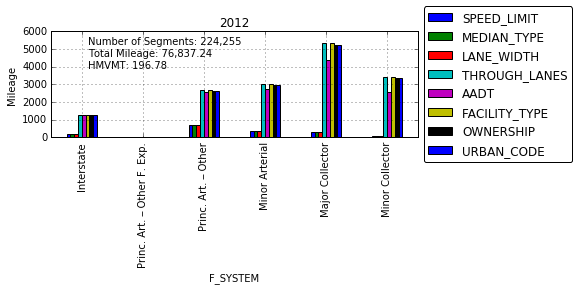

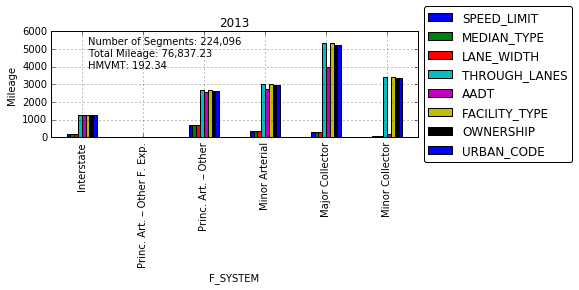

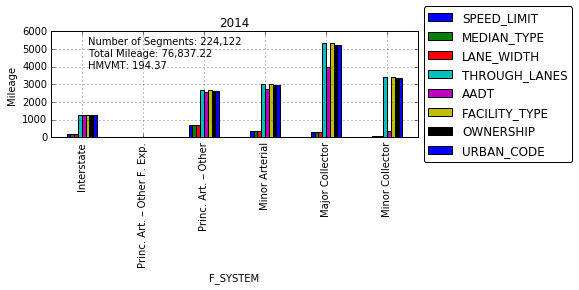

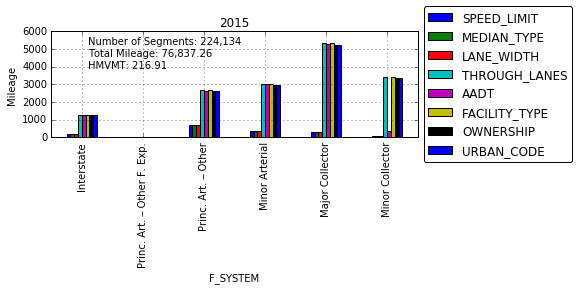

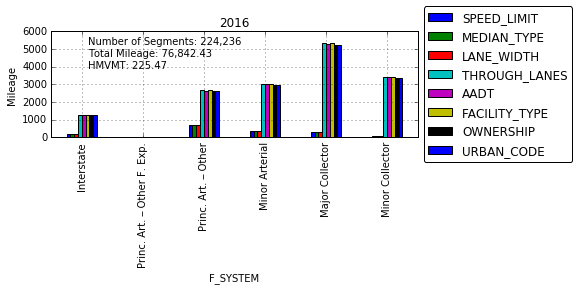

In [104]:
#Segs_Dict = {year:hsmpy3.common.AttributeTabletoDF(Segs[year],True) for year in Years}
left, width = .1, .85
bottom, height = .1, .85
right = left + width
top = bottom + height    
for i,year in enumerate(Years):
    df1 = Segs_DF[Segs_DF.Year==year]
    df = df1[(df1.P3 =='P')]
    vmt = sum(df.VMT)/100000000.0
    ls = list(df.Mileage)
    df = FCoverage[FCoverage.Year==year]
    df.plot(x=["F_SYSTEM"], y=["SPEED_LIMIT","MEDIAN_TYPE","LANE_WIDTH","THROUGH_LANES","AADT","FACILITY_TYPE",'OWNERSHIP','URBAN_CODE'], 
                 kind="bar",grid=True,title=str(year),ax=plt.figure().gca())

    plt.gca().text(left, top,'Number of Segments: {:0,.0f}\nTotal Mileage: {:0,.2f}\nHMVMT: {:0,.2f}'.format(len(ls),sum(ls),vmt),
        horizontalalignment='left',
        verticalalignment='top',
        transform=plt.gca().transAxes)
    lgd = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fancybox = True)
    plt.gca().set_ylabel("Mileage")
    plt.tight_layout()
    
    plt.savefig('FC_wolb_{}.png'.format(year),transparent=True,bbox_extra_artists=(lgd,), bbox_inches='tight')

In [21]:
df = hsmpy3.common.AttributeTabletoDF(Routes[2016],False)
df['P1'] = [r.ROUTE_ID.split('-')[0] for i,r in df.iterrows()]
df['P2'] = [r.ROUTE_ID.split('-')[1] for i,r in df.iterrows()]
df['P3'] = [r.ROUTE_ID.split('-')[2] for i,r in df.iterrows()]
df['Len']= df.Shape_Length/5280
df['RNLen'] = [len(r.P2) for i,r in df.iterrows()]

print(sum(df.Len))
df2 = pd.DataFrame(df.groupby(['P1','P3']).Len.aggregate(np.sum))
display(df2)

78314.0097776


Len
P1  P3          
BIA P     204.37
BL  M      26.21
    P      64.54
DD  P      37.08
FL  M     177.14
    P   4,388.42
FLX P       1.08
FR  P     815.60
FS  P     250.30
FW  P      14.22
I   M     608.48
    P   1,384.76
IX  P     327.97
LOC P  55,564.42
NM  M     175.69
    P   9,469.78
NMX P      13.53
US  M     687.40
    P   4,071.15
USX P      31.89

In [44]:
df = pd.concat([hsmpy3.common.FCtoDF(Segs[y]) for y in range(2012,2017)])
df = df[df.AADT>0]
df = df[~pd.isnull(df.AADT)]
df['VMT'] = df.AADT*df.Shape_Length/5280.0*365

In [ ]:
idf = pd.concat([hsmpy3.common.FCtoDF(Segs[y]) for y in range(2012,2017)])
df = df[df.AADT>0]
df = df[~pd.isnull(df.AADT)]
df['VMT'] = df.AADT*df.Shape_Length/5280.0*365

In [41]:
vdf = pd.DataFrame(df.groupby('FType')['VMT'].aggregate(np.sum))
vdf['VMT2'] = vdf.VMT/sum(vdf.VMT)*100
vdf = vdf.sort_values('VMT',ascending=False)
vdf = vdf.loc[['R4F','U4F','U6F','R2U','R4U','R4D','U2U','U4U','U6U']]
vdf['CUMSUM'] = vdf.VMT2.cumsum()
display(vdf)
sum(vdf.VMT)/100000000.0

,VMT,VMT2,CUMSUM
FType,,,
R4F,4.263592e+09,19.060730,19.060730
U4F,9.908877e+08,4.429842,23.490572
U6F,1.110585e+09,4.964960,28.455532
R2U,4.498020e+09,20.108760,48.564292
R4U,2.235182e+09,9.992560,58.556852
R4D,5.952485e+08,2.661106,61.217958
U2U,2.627992e+09,11.748649,72.966607
U4U,2.947025e+09,13.174913,86.141520
U6U,9.631505e+08,4.305841,90.447361


202.31684633253414

In [25]:
Loc_DF['Measurement2'] = Loc_DF.Measurement.astype(str).astype(float,errors='ignore')

In [50]:
Loc_DF.IntID = Loc_DF.IntID.fillna(0)
Loc_DF[(Loc_DF.ConvOffset>0) & (Loc_DF.IntID>0) & (Loc_DF.CrashesAtThisLoc!=545) & (Loc_DF.CrashesAtThisLoc>1)][['Measurement', 'MeasurementUnit','CrashesAtThisLoc','ConvOffset','IntID']]

,Measurement,MeasurementUnit,CrashesAtThisLoc,ConvOffset,IntID
CID,,,,,
2012_12091498,0.6,MI,2,6.000000,67446.0
2012_22677851,150,FT,3,0.028409,2335.0
2012_23155715,287,FT,2,0.054356,416.0
2012_23177221,.04,MI,2,4.000000,56342.0
2012_23200380,2.1,FT,2,0.003977,9080.0
2012_23200480,6,MI,2,6.000000,20635.0
2012_23232480,100,FT,5,0.018939,2450.0
2012_23238708,738,FT,3,0.139773,57766.0
2012_23243646,20,FT,3,0.003788,55571.0


In [52]:
def Assignment(i):
    if pd.isnull(i):
        return('Not Assigned')
    if i==0:
        return('Roadway')
    if i>0:
        return('Intersection')
Loc_DF.index = Loc_DF.CID
Loc_DF['IntID'] = Crash_DF.Int_ID.loc[Loc_DF.index]
Loc_DF.IntID.apply(Assignment).value_counts()

C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


Intersection    14375
Roadway          8025
Not Assigned      706
Name: IntID, dtype: int64

Intersection


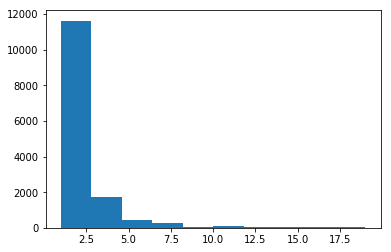

Roadway


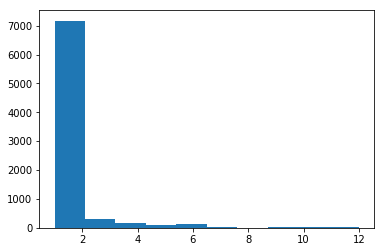

Not Assigned


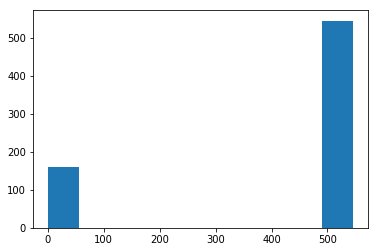

In [63]:
Loc_DF['Assignment'] = Loc_DF.IntID.apply(Assignment)
for a in list(Loc_DF.Assignment.value_counts().index):
    print(a)
    plt.hist(Loc_DF[Loc_DF.Assignment==a].CrashesAtThisLoc)
    plt.show()

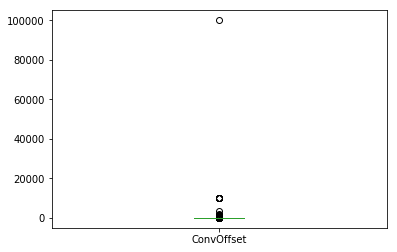

In [72]:
Loc_DF[(Loc_DF.IntID>0) & (Loc_DF.ConvOffset>250)].ConvOffset.apply(lambda x:x/5280.0).plot(kind='box')

In [75]:
Loc_DF.Assignment.value_counts(True)
def GetM(m):
    if pd.isnull(m):
        return('Not Reported')
    if m<=250:
        return('Less than 250-foot')
    if m>250:
        return('More than 250-foot')
    
Loc_DF['MeasurementFromLandmark'] = Loc_DF.ConvOffset.apply(GetM)
Loc_DF['MeasurementFromLandmark'].value_counts()

Not Reported          15112
More than 250-foot     5390
Less than 250-foot     2604
Name: MeasurementFromLandmark, dtype: int64

In [80]:
df = pd.DataFrame(Loc_DF.groupby(['year','Assignment','MeasurementFromLandmark']).size())
df.unstack(0)

0                        
year                                  2012  2013  2014  2015  2016
Assignment   MeasurementFromLandmark                              
Intersection Less than 250-foot        459   343   256   354   306
             More than 250-foot        368   371   439   366   273
             Not Reported             1743  1934  2087  2469  2607
Not Assigned Less than 250-foot         84    25    10     4     1
             More than 250-foot         72    42    31     9     1
             Not Reported              172   143    52    28    32
Roadway      Less than 250-foot        209   152   113   145   143
             More than 250-foot        783   643   750   703   539
             Not Reported              543   599   721   834  1148

In [77]:
Loc_DF

,year,UCRnumber,CrashDate,Month,MilitaryTime,Hour,Day,Agency,County,City,...,TraCS,dateAddedDB,CID,XY,CrashesAtThisLoc,Measurement2,ConvOffset,IntID,Assignment,MeasurementFromLandmark
CID,,,,,,,,,,,,,,,,,,,,,
2012_10027290,2012,10027290,09/11/2012,9,16:10,16,3,535,18,340,...,0,NaN,2012_10027290,161938.2314_3935252.26,1,0.2,10560.0,42981.0,Intersection,More than 250-foot
2012_10153388,2012,10153388,02/16/2012,2,10:26,10,5,45,25,115,...,0,NaN,2012_10153388,233646.7135_4066992.6980000003,2,nan,NaN,6038.0,Intersection,Not Reported
2012_10153400,2012,10153400,03/06/2012,3,16:35,16,3,45,25,115,...,0,NaN,2012_10153400,232699.4337_4067013.0930000003,1,nan,NaN,2566.0,Intersection,Not Reported
2012_10303496,2012,10303496,05/07/2012,5,02:40,2,2,1001,1,30,...,0,NaN,2012_10303496,364977.7874_3895328.8880000003,1,650,650.0,0.0,Roadway,More than 250-foot
2012_10395450,2012,10395450,01/02/2012,1,11:28,11,2,1001,1,0,...,0,NaN,2012_10395450,347776.0371_3871820.4439999997,1,0,0.0,0.0,Roadway,Less than 250-foot
2012_10395480,2012,10395480,01/09/2012,1,21:00,21,2,1001,1,806,...,0,NaN,2012_10395480,374124.1058_3883639.577,1,0,0.0,0.0,Roadway,Less than 250-foot
2012_10395507,2012,10395507,01/17/2012,1,06:32,6,3,1001,1,0,...,0,NaN,2012_10395507,325175.8232_3879043.617,3,0,0.0,0.0,Roadway,Less than 250-foot
2012_10395508,2012,10395508,01/17/2012,1,07:21,7,3,1001,1,30,...,0,NaN,2012_10395508,325175.8232_3879043.617,3,0,0.0,0.0,Roadway,Less than 250-foot
2012_10395543,2012,10395543,01/21/2012,1,12:12,12,7,1001,1,30,...,0,NaN,2012_10395543,345251.6592_3881815.4269999997,1,0,0.0,10577.0,Intersection,Less than 250-foot


In [68]:
def Measurement(m,u):
    try:
        m = str(m)
        m = m.replace(',','').replace("*","").replace(".","").strip("'").replace("'","")
        m = float(m)
        u = str(u)
    except:
        print('Failed',m,u)
        return(np.NaN)
    if u=='MI':
        return(m*5280.0)
    if u=='FT':
        return(m)
Loc_DF['ConvOffset'] = [Measurement(m,u) for m,u in zip(Loc_DF.Measurement,Loc_DF.MeasurementUnit)]
Loc_DF

Failed  99


,year,UCRnumber,CrashDate,Month,MilitaryTime,Hour,Day,Agency,County,City,...,StampDate,TraCS,dateAddedDB,CID,XY,CrashesAtThisLoc,Measurement2,ConvOffset,IntID,Assignment
CID,,,,,,,,,,,,,,,,,,,,,
2012_10027290,2012,10027290,09/11/2012,9,16:10,16,3,535,18,340,...,09/14/2012,0,NaN,2012_10027290,161938.2314_3935252.26,1,0.2,10560.0,42981.0,Intersection
2012_10153388,2012,10153388,02/16/2012,2,10:26,10,5,45,25,115,...,02/21/2012,0,NaN,2012_10153388,233646.7135_4066992.6980000003,2,nan,NaN,6038.0,Intersection
2012_10153400,2012,10153400,03/06/2012,3,16:35,16,3,45,25,115,...,04/13/2012,0,NaN,2012_10153400,232699.4337_4067013.0930000003,1,nan,NaN,2566.0,Intersection
2012_10303496,2012,10303496,05/07/2012,5,02:40,2,2,1001,1,30,...,06/06/2012,0,NaN,2012_10303496,364977.7874_3895328.8880000003,1,650,650.0,0.0,Roadway
2012_10395450,2012,10395450,01/02/2012,1,11:28,11,2,1001,1,0,...,09/10/2012,0,NaN,2012_10395450,347776.0371_3871820.4439999997,1,0,0.0,0.0,Roadway
2012_10395480,2012,10395480,01/09/2012,1,21:00,21,2,1001,1,806,...,08/08/2012,0,NaN,2012_10395480,374124.1058_3883639.577,1,0,0.0,0.0,Roadway
2012_10395507,2012,10395507,01/17/2012,1,06:32,6,3,1001,1,0,...,08/16/2012,0,NaN,2012_10395507,325175.8232_3879043.617,3,0,0.0,0.0,Roadway
2012_10395508,2012,10395508,01/17/2012,1,07:21,7,3,1001,1,30,...,08/15/2012,0,NaN,2012_10395508,325175.8232_3879043.617,3,0,0.0,0.0,Roadway
2012_10395543,2012,10395543,01/21/2012,1,12:12,12,7,1001,1,30,...,09/04/2012,0,NaN,2012_10395543,345251.6592_3881815.4269999997,1,0,0.0,10577.0,Intersection


,year,UCRnumber,CrashDate,Month,MilitaryTime,Hour,Day,Agency,County,City,...,FormID,SysScanDate,StampDate,TraCS,dateAddedDB,CID,XY,CrashesAtThisLoc,Measurement2,ConvOffset
XY,,,,,,,,,,,,,,,,,,,,,
161938.2314_3935252.26,2012,10027290,09/11/2012,9,16:10,16,3,535,18,340,...,UCR UNKNOWN,07/17/2013,09/14/2012,0,NaN,2012_10027290,161938.2314_3935252.26,1,0.2,2.000000
364977.7874_3895328.8880000003,2012,10303496,05/07/2012,5,02:40,2,2,1001,1,30,...,UCR APRIL 2002 REVISED,07/08/2013,06/06/2012,0,NaN,2012_10303496,364977.7874_3895328.8880000003,1,650,0.123106
355798.0782_3893521.627,2012,10397664,09/25/2012,9,17:21,17,3,1001,1,30,...,UCR FEB 9 2005 REVISED,07/02/2013,02/12/2013,0,NaN,2012_10397664,355798.0782_3893521.627,5,0.2,2.000000
374064.7986_3878301.01,2012,10397679,10/20/2012,10,16:30,16,7,1001,1,0,...,UCR FEB 9 2005 REVISED,06/28/2013,02/12/2013,0,NaN,2012_10397679,374064.7986_3878301.01,1,0.4,4.000000
349258.5687_3891965.0939999996,2012,10397681,10/25/2012,10,21:15,21,5,1001,1,30,...,UCR FEB 9 2005 REVISED,06/28/2013,02/12/2013,0,NaN,2012_10397681,349258.5687_3891965.0939999996,1,210,0.039773
377005.723_3885210.048,2012,10397775,11/21/2012,11,19:08,19,4,1001,1,0,...,UCR FEB 9 2005 REVISED,06/24/2013,12/13/2012,0,NaN,2012_10397775,377005.723_3885210.048,2,450,0.085227
352981.5585_3893770.3260000004,2012,10397858,07/08/2012,7,23:29,23,1,1001,1,30,...,UCR FEB 9 2005 REVISED,06/25/2013,01/04/2013,0,NaN,2012_10397858,352981.5585_3893770.3260000004,1,1107,0.209659
343916.9603_3882132.847,2012,10397894,11/22/2012,11,17:05,17,5,1001,1,30,...,UCR FEB 9 2005 REVISED,06/26/2013,01/04/2013,0,NaN,2012_10397894,343916.9603_3882132.847,1,34,0.006439
356436.6553_3896712.894,2012,10397950,12/16/2012,12,01:13,1,1,1001,1,30,...,UCR FEB 9 2005 REVISED,06/25/2013,01/04/2013,0,NaN,2012_10397950,356436.6553_3896712.894,1,1240,0.234848


In [12]:
Loc_DF['XY'] = ['{}_{}'.format(x,y) for x,y in zip(Loc_DF.GIS_UTMX,Loc_DF.GIS_UTMY)]
df = pd.DataFrame(Loc_DF.groupby('XY').size())
Loc_DF.index = Loc_DF.XY
Loc_DF['CrashesAtThisLoc'] = df[0].loc[Loc_DF.index]


C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:2: FutureWarning: 'XY' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


In [13]:
Loc_DF

,year,UCRnumber,CrashDate,Month,MilitaryTime,Hour,Day,Agency,County,City,...,NMDOTNumber,CADNumber,FormID,SysScanDate,StampDate,TraCS,dateAddedDB,CID,XY,CrashesAtThisLoc
XY,,,,,,,,,,,,,,,,,,,,,
161938.2314_3935252.26,2012,10027290,09/11/2012,9,16:10,16,3,535,18,340,...,NaN,NaN,UCR UNKNOWN,07/17/2013,09/14/2012,0,NaN,2012_10027290,161938.2314_3935252.26,1
233646.7135_4066992.6980000003,2012,10153388,02/16/2012,2,10:26,10,5,45,25,115,...,NaN,NaN,UCR UNKNOWN,05/23/2013,02/21/2012,0,NaN,2012_10153388,233646.7135_4066992.6980000003,2
232699.4337_4067013.0930000003,2012,10153400,03/06/2012,3,16:35,16,3,45,25,115,...,NaN,NaN,UCR UNKNOWN,04/16/2013,04/13/2012,0,NaN,2012_10153400,232699.4337_4067013.0930000003,1
364977.7874_3895328.8880000003,2012,10303496,05/07/2012,5,02:40,2,2,1001,1,30,...,NaN,12626475,UCR APRIL 2002 REVISED,07/08/2013,06/06/2012,0,NaN,2012_10303496,364977.7874_3895328.8880000003,1
347776.0371_3871820.4439999997,2012,10395450,01/02/2012,1,11:28,11,2,1001,1,0,...,10395450,NaN,UCR FEB 9 2005,NaN,09/10/2012,0,NaN,2012_10395450,347776.0371_3871820.4439999997,1
374124.1058_3883639.577,2012,10395480,01/09/2012,1,21:00,21,2,1001,1,806,...,NaN,NaN,UCR FEB 8 2009 REVISED,NaN,08/08/2012,0,NaN,2012_10395480,374124.1058_3883639.577,1
325175.8232_3879043.617,2012,10395507,01/17/2012,1,06:32,6,3,1001,1,0,...,10395507,NaN,UCR FEB 9 2005,NaN,08/16/2012,0,NaN,2012_10395507,325175.8232_3879043.617,3
325175.8232_3879043.617,2012,10395508,01/17/2012,1,07:21,7,3,1001,1,30,...,NaN,NaN,UCR FEB 9 2005,NaN,08/15/2012,0,NaN,2012_10395508,325175.8232_3879043.617,3
345251.6592_3881815.4269999997,2012,10395543,01/21/2012,1,12:12,12,7,1001,1,30,...,10395543,NaN,UCR FEB 9 2005,NaN,09/04/2012,0,NaN,2012_10395543,345251.6592_3881815.4269999997,1
